# Exploring Autofluorescence and Delta Distributions

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [63]:
import sys 
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import glob
import altair as alt
import altair_catplot as altcat
import matplotlib.pyplot as plt
import act.viz
import pystan
import bebi103.viz
import bokeh.io
colors = act.viz.personal_style()
alt.renderers.enable('json')

%load_ext stanmagic
bokeh.io.output_notebook()

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


Loading BokehJS ...

In [85]:
# Load all simple and wt flow settings. 
simple_delta_files = glob.glob('../../data/flow/csv/*27yfp*delta*.csv')
simple_auto_files = glob.glob('../../data/flow/csv/*27yfp*auto*.csv')
dfs = []
for d, a in zip(simple_delta_files, simple_auto_files):
    d_date = d.split('/')[-1].split('_')[0]
    a_date = a.split('/')[-1].split('_')[0]
    d_df = pd.read_csv(d)[['gate','FITC-H']]
    a_df = pd.read_csv(a)[['FITC-H', 'gate']]
    d_df['date'] = d_date
    d_df['strain'] = 'delta'
    a_df['date'] = a_date
    a_df['strain'] = 'auto'
    dfs.append(d_df)
    dfs.append(a_df)
simple_df = pd.concat(dfs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


(100.0, 1000.0)

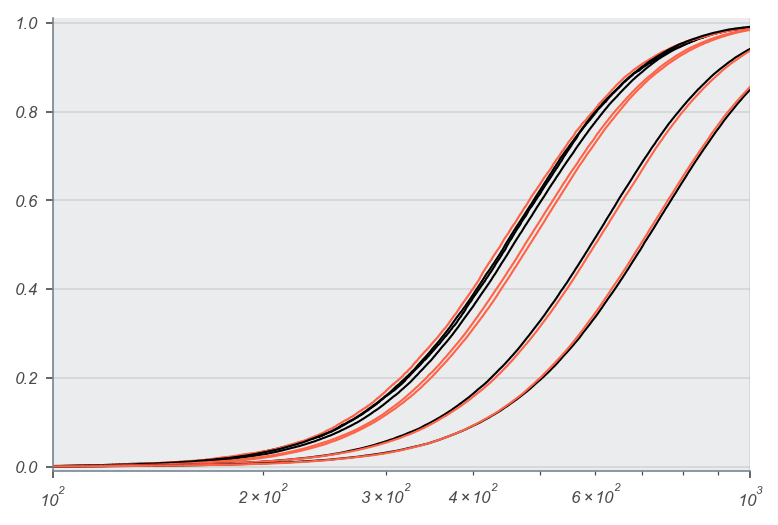

In [86]:
fig, ax = plt.subplots(1, 1)
_colors = {'auto':'black',
           'delta':'tomato'}

for g, d in simple_df.groupby(['date', 'strain']):
    _d = d[d['gate']==1].copy()
    x = np.sort(d['FITC-H'])
    y = np.linspace(0, 1, len(d))
    ax.step(x, y, color=_colors[g[1]], lw=1) 
    
ax.set_xscale('log')
ax.set_xlim([1E2, 1E3])

In [73]:
means = simple_df[simple_df['gate']==1].groupby(['date', 'strain'])['FITC-H'].mean().reset_index()
means

,date,strain,FITC-H
0,20190131,auto,24587.528620
1,20190131,delta,22907.362154
2,20190201,auto,23547.460561
3,20190201,delta,24126.754343
4,20190204,auto,25482.966159
5,20190204,delta,26705.866777
6,20190205,auto,27327.910822
7,20190205,delta,27750.381200
8,20190206,auto,30095.359199
9,20190206,delta,30326.174633


In [89]:
grouped =  simple_df[simple_df['gate']==1].groupby(['date', 'strain'])['FITC-H'].mean().reset_index()




In [41]:
(recording)[l]

NameError: name 'recording' is not defined

In [79]:
%%stan -v hier_model
data {
    int<lower=0> N;
    real<lower=0> mean_auto[N];
    real<lower=0> mean_delta[N];
}

parameters {
    real<lower=0> mu_auto;
    real<lower=0> mu_delta;
    real<lower=0> sigma;
}

model {
    mu_auto ~ lognormal(2, 2);
    mu_delta ~ lognormal(2, 2);
    sigma ~ normal(0, 10);
    
    for (i in 1:N) {
        mean_auto ~ normal(mu_auto, sigma);
        mean_delta ~ normal(mu_delta, sigma);
    }
}


Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in hier_model object.
Type hier_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^
Access model compile output properties
hier_model.model_file -> Name of stan_file [None]
hier_model.model_name -> Name of stan model [None]
hier_model.model_code -> Model code [data {     int<lower ....]


In [ ]:
model = pystan.StanModel(model_code=hier_model.model_code)

In [90]:
data_dict = {'N': len(simple_df['date'].unique()),
             'mean_auto': grouped[grouped['strain']=='auto']['FITC-H'], 
             'mean_delta':  grouped[grouped['strain']=='delta']['FITC-H']}
samples = model.sampling(data_dict)
samples_df = samples.to_dataframe()

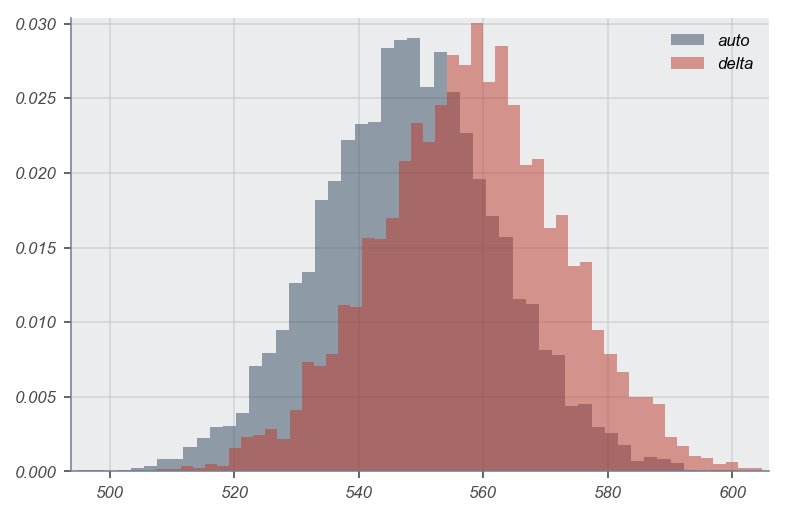

In [91]:
fig, ax = plt.subplots(1, 1)
ax.hist(samples_df['mu_auto'], bins=50, label='auto', 
           density=True, histtype='stepfilled', alpha=0.5)
ax.hist(samples_df['mu_delta'], bins=50, label='delta',
           density=True, histtype='stepfilled', alpha=0.5)
plt.legend()

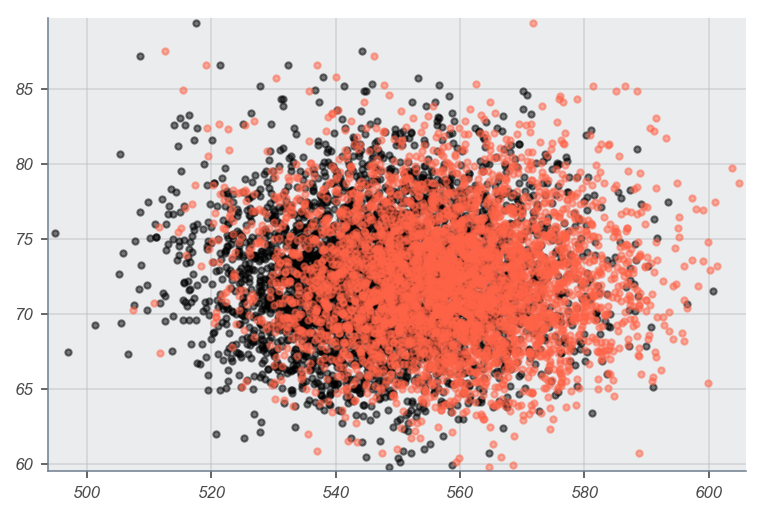

In [94]:
plt.plot(samples_df['mu_auto'], samples_df['sigma'], '.', color='black', alpha=0.5)
plt.plot(samples_df['mu_delta'], samples_df['sigma'], '.', color='tomato', alpha=0.5)

## Computing hierarchical fold-change 

In [363]:
%%stan -v fc_hier
data {
    int<lower=0> N_auto; // Total number of measurements
    int<lower=0> N_delta;
    int<lower=0> N;
    int<lower=0> J; // Total number of concentrations
    int<lower=0, upper=J> idx[N]; 
    vector<lower=0>[N]  means;  
    vector<lower=0>[N_auto] autofl;
    vector<lower=0>[N_delta] delta;
}

parameters {
    real<lower=0> mu_auto;
    real<lower=0> mu_delta;
    real<lower=0> sigma_auto;
    real<lower=0> sigma_delta;
    real<lower=0> mu[J];
    real<lower=0> sigma[J];
    
}

model {
    mu ~ lognormal(3, 2);
    mu_auto ~ lognormal(2, 2);
    mu_delta ~ lognormal(2, 2);
    sigma_auto ~ normal(0, 10);
    sigma_delta ~ normal(0, 10);
    sigma ~ normal(0, 10);
    autofl ~ normal(mu_auto, sigma_auto);
    delta ~ normal(mu_delta, sigma_delta);
    for (i in 1:N) {
        means[i] ~ normal(mu[idx[i]], sigma[idx[i]]);
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in fc_hier object.
Type fc_hier in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^
Access model compile output properties
fc_hier.model_file -> Name of stan_file [None]
fc_hier.model_name -> Name of stan model [None]
fc_hier.model_code -> Model code [data {     int<lower ....]


In [ ]:
model = pystan.StanModel(model_code=fc_hier.model_code)

In [365]:
# Load the data sets. 
data = pd.concat([pd.read_csv(f) for f in glob.glob('../processing/*27yfp*xan*/output/*fold_change*.csv')])
data = data[['date', 'promoter', 'strain', 'xan_mgml', 'mean_FITC']]

In [366]:
idx = data.groupby(['xan_mgml']).ngroup() + 1
data['idx'] = idx
xan_concs = {i:x for i, x in zip(data[data['strain']=='dilution']['idx'],
                                 data[data['strain']=='dilution']['xan_mgml'])}



In [367]:
data_dict = {'N':len(data[data['strain']=='dilution']), 
             'N_auto': len(data[data['strain']=='auto']),
             'N_delta': len(data[data['strain']=='delta']),
             'autofl': data[data['strain']=='auto']['mean_FITC'],
             'delta': data[data['strain']=='delta']['mean_FITC'],
             'J':data['idx'].max(),
             'idx':data[data['strain']=='dilution']['idx'].astype(int), 
             'means':data[data['strain']=='dilution']['mean_FITC']}
samples = model.sampling(data_dict, iter=10000, control=dict(adapt_delta=0.95))

In [368]:
samples

Inference for Stan model: anon_model_59aa0bc28864ccac8693b8e03bb8393f.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_auto     547.03     0.1  21.05 505.66 533.11 547.04 561.06 588.82  42336    1.0
mu_delta    557.28     0.1  20.36 516.95 543.41 557.37 570.86 596.99  40673    1.0
sigma_auto   47.21    0.02   4.81   38.6   43.8  46.94  50.31  57.26  40525    1.0
sigma_delta  45.47    0.02   4.77  36.92  42.15  45.21   48.5  55.57  42545    1.0
mu[1]       559.44    0.09   18.0 523.71 547.45 559.38 571.41 595.04  38710    1.0
mu[2]       612.32     0.1   17.6 576.91 601.05 612.42 623.95 646.69  34173    1.0
mu[3]        620.0    0.11  22.48  575.6 605.05 620.07 635.13 664.02  43363    1.0
mu[4]       1311.9    0.28  59.93 1193.2 1272.3 1312.1 1351.9 1430.1  44712    1.0
mu[5]       2264.7    0.32  71.22 2125.5 2217.2 2265.5 2312.6 

In [369]:
xan_concs

{7: 1.0,
 3: 0.1,
 13: 4.0,
 12: 3.5,
 11: 3.0,
 2: 0.05,
 10: 2.5,
 5: 0.5,
 6: 0.75,
 8: 1.5,
 4: 0.25,
 1: 0.0,
 9: 2.0,
 15: 6.0,
 17: 8.0,
 14: 5.0,
 16: 7.0,
 18: 10.0}

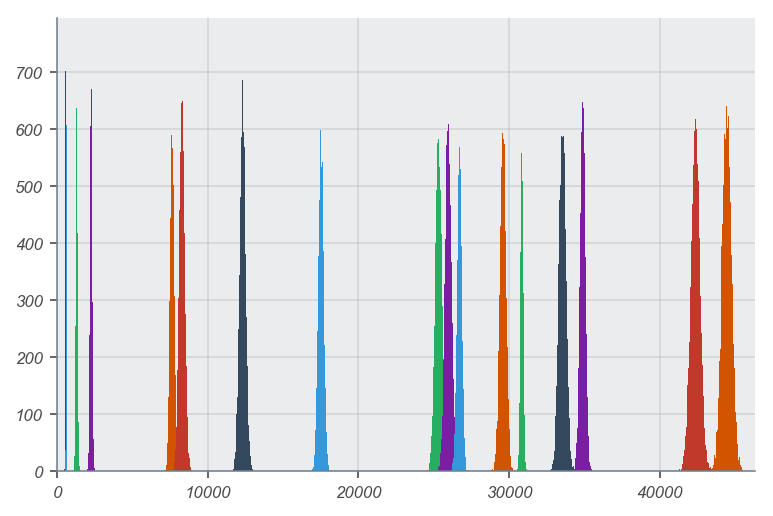

In [372]:
samples_df = samples.to_dataframe()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
bins = np.logspace(1, 5, 200)

for i in range(data['idx'].max()):
    ax.hist(samples_df[f'mu[{i+1}]'], bins=100)


In [374]:
samples_df.mean().reset_index()

,index,0
0,chain,2.500000
1,chain_idx,2500.500000
2,warmup,0.000000
3,divergent__,0.000000
4,energy__,18598.797871
5,treedepth__,3.952950
6,accept_stat__,0.949031
7,stepsize__,0.335550
8,n_leapfrog__,14.749600
9,mu_auto,547.033324
